# 데이터, 패키지 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math

import datetime
from datetime import datetime, date

from sklearn.ensemble import *
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adamax
from keras.models import load_model
from keras import models

pd.options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
access = pd.read_csv('UserAccess.csv')
action = pd.read_csv('UserAction.csv')
purchase = pd.read_csv('UserPurchase.csv')

In [3]:
access.head()

,UID,logdate,country,city,language,platform,device_brand
0,11058552,2019-10-21,ID,Simomulyo,Bahasa Indonesia,android,OPPO
1,12645389,2019-10-23,KZ,Pavlodar,русский,android,Neffos
2,12687076,2019-10-21,UK,Tunbridge Wells,English,android,samsung
3,12713117,2019-11-26,RU,Kaspysk,русский,android,HUAWEI
4,12713117,2019-11-27,RU,Kaspysk,русский,android,HUAWEI


In [4]:
action.head()

,UID,logdate,PlayTime,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,TotalEquipments,...,Tier6Equip,Tier7Equip,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,isClanMember,PlayerLevel
0,11058552,2017-05-13,826,1125,125,0,34192,14700,1508,1,...,0,0,0,0,0,1,0,0,N,1
1,11058552,2019-10-21,77,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,N,1
2,12645389,2017-05-11,357688,1107,41875,41768,439340,4426637,4017862,5,...,0,0,0,0,0,9,3,100,N,42
3,12645389,2017-05-12,674818,1033,31490,31564,40040,4127092,4525835,5,...,0,0,0,0,0,5,2,67,N,45
4,12645389,2017-05-13,403518,1952,5410,4491,316227,1153988,877800,5,...,0,0,0,0,0,0,0,0,N,45


In [5]:
purchase.head()

,UID,logtime,payID,product_id,product_price
0,27878963,2019-10-01T05:58:55.574Z,P3863,package17,1800
1,27878963,2019-10-01T05:59:15.330Z,P5067,package18,1800
2,27878963,2019-10-01T05:59:35.823Z,P7328,package211,1800
3,27878963,2019-10-01T05:59:55.685Z,P5742,package212,1800
4,27878963,2019-10-01T06:04:47.071Z,P976,package122,24600


# 과제1. 진성유저 판별

진성유저를 유저 판별을 위해 위 데이터로 3가지 변수가 추론 가능하다고 생각했다.

- 평균 플레이 타임 : 접속 횟수 대비 총 플레이타임이 길면 진성유저
- 최대 레벨 : 최대 레벨이 높으면 진성유저
- 구매 금액 : 게임에 과금금액 총액이 많으면 진성유저

이 세 항목이 적절히 크다면 진성유저로 판별할 수 있다.

## 평균 플레이 타임

In [6]:
user=pd.merge(action.groupby('UID').sum()['PlayTime'],action.groupby('UID').count()['logdate'],on='UID')

In [7]:
user.columns=['TotalPlayTime','PlayTimeCount']

In [8]:
user['PlayTimeMean']=user['TotalPlayTime']/user['PlayTimeCount']

## 최대 플레이어 레벨

In [9]:
LevelMax=action.groupby('UID').max()['PlayerLevel']

In [10]:
user=pd.merge(user,LevelMax,on='UID')

## 총 구매 금액

In [11]:
user=pd.merge(user,purchase.groupby('UID').sum(),on='UID',how='left')

In [12]:
user=user.reset_index()

In [13]:
user['product_price']=user['product_price'].replace(np.NaN, 0)

In [14]:
del user['TotalPlayTime']
del user['PlayTimeCount']

In [15]:
user.head()

,UID,PlayTimeMean,PlayerLevel,product_price
0,1072937,304.0,1,0.0
1,1072938,320.0,1,0.0
2,1073002,0.0,4,0.0
3,1073004,2311.0,23,0.0
4,1073096,153.0,1,0.0


## 변수 스케일링

### 평균 플레이 타임
플레이 타임은 대부분이 0주위에 있지만, 진성유저들의 플레이타임과는 매우 거리가 멀다. 따라서, 이를 극단값으로 규정하고 극단값을 보정할 수 있는 로그 변환을 실시한다.

(array([5.7046e+04, 1.1600e+02, 6.0000e+00, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([     0.        ,  21971.44444444,  43942.88888889,  65914.33333333,
         87885.77777778, 109857.22222222, 131828.66666667, 153800.11111111,
        175771.55555556, 197743.        , 219714.44444444]),
 <a list of 10 Patch objects>)

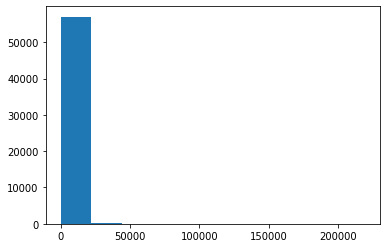

In [16]:
plt.hist(user['PlayTimeMean'])

(array([3.3510e+03, 9.9000e+01, 7.3100e+02, 4.6530e+03, 1.7165e+04,
        1.8138e+04, 1.0214e+04, 2.6180e+03, 1.9900e+02, 5.0000e+00]),
 array([-3.09774613, -2.47200048, -1.84625483, -1.22050918, -0.59476353,
         0.03098212,  0.65672778,  1.28247343,  1.90821908,  2.53396473,
         3.15971038]),
 <a list of 10 Patch objects>)

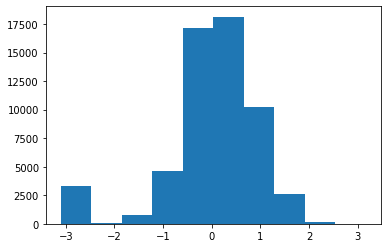

In [17]:
user['PlayTimeMean'] = preprocessing.scale(np.log(user['PlayTimeMean']+1)) # 로그
plt.hist(user['PlayTimeMean'])

대체로 0 주위에 잘 모여 있으며, 플레이타임이 아예없는 유저는 -3 으로 보정되었고, 플레이타임이 많은 유저의 값 또한 잘 보정되었다.

### 총 구매 금액
총 구매 금액 또한 과금을 한 유저와 과금을 하지 않은 유저의 총액 차이가 매우 컸다.
EDA 결과, 평균금액인 2460단위 과금보다 많은 과금을 한 유저는 925명 밖에 되지 않았다. 이는 전체 57000여명의 데이터 중 매우 적은 수치이며, 평균 이상의 금액을 과금한 유저들은 특히 과금 금액이 매우 크다고 할 수 있다.
아래 히스토그램을 확인하면 무과금~소과금 유저들의 층은 매우 많다고 볼 수 있다. 따라서 이를 조정하고자 로그 변환을 하되, 중간층이 없다는 것을 감안하고 분석을 진행한다.

In [18]:
print(user['product_price'].mean(), len(user[user['product_price']>user['product_price'].mean()]))

2460.9203645077223 925


(array([5.7165e+04, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([       0.,  2053260.,  4106520.,  6159780.,  8213040., 10266300.,
        12319560., 14372820., 16426080., 18479340., 20532600.]),
 <a list of 10 Patch objects>)

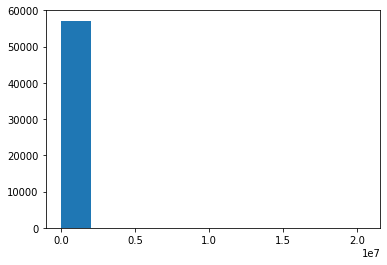

In [19]:
plt.hist(user['product_price'])

(array([5.598e+04, 0.000e+00, 0.000e+00, 0.000e+00, 3.680e+02, 4.700e+02,
        2.340e+02, 9.200e+01, 2.600e+01, 3.000e+00]),
 array([-0.14364679,  1.08264371,  2.30893421,  3.53522471,  4.76151521,
         5.9878057 ,  7.2140962 ,  8.4403867 ,  9.6666772 , 10.8929677 ,
        12.11925819]),
 <a list of 10 Patch objects>)

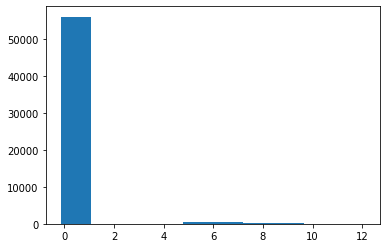

In [20]:
user['product_price'] = preprocessing.scale(np.log(user['product_price']+1)) 
plt.hist(user['product_price'])

In [21]:
user.head(10) #최종 데이터

,UID,PlayTimeMean,PlayerLevel,product_price
0,1072937,-0.187637,1,-0.143647
1,1072938,-0.161626,1,-0.143647
2,1073002,-3.097746,4,-0.143647
3,1073004,0.842830,23,-0.143647
4,1073096,-0.535284,1,-0.143647
5,1073133,-0.450298,1,-0.143647
6,1073134,0.474562,1,-0.143647
7,1073152,0.653170,4,-0.143647
8,1073154,0.032350,1,-0.143647
9,1073159,1.540965,10,-0.143647


# 모형적합
k-평균 알고리즘은 주어진 데이터를 k개의 클러스터로 묶는 알고리즘으로, 각 클러스터와 거리 차이의 분산을 최소화하는 방식으로 동작한다. 주어진 feature에 대해 일정한 거리 안에 있는 데이터들을 클러스터링하고, 이들의 특징에 대해 알아보도록 한다.

In [22]:
X=np.array(user.iloc[:,1:4])
X

array([[-0.18763682,  1.        , -0.14364679],
       [-0.16162566,  1.        , -0.14364679],
       [-3.09774613,  4.        , -0.14364679],
       ...,
       [-0.56242278,  1.        , -0.14364679],
       [ 0.47592211,  1.        , -0.14364679],
       [-0.94371796,  1.        , -0.14364679]])

In [23]:
scaler=StandardScaler()
X_train_scale=scaler.fit_transform(X)

In [24]:
X=pd.DataFrame(X_train_scale,columns=user.columns[1:4])

In [25]:
model = KMeans(n_clusters=4,algorithm='auto')
feature = X[['PlayTimeMean','PlayerLevel','product_price']]

In [26]:
model.fit(feature)
predict = pd.DataFrame(model.predict(feature))
predict.columns=['predict']

In [27]:
r = pd.concat([user['UID'],feature,predict],axis=1)

In [28]:
r

,UID,PlayTimeMean,PlayerLevel,product_price,predict
0,1072937,-0.187637,-0.493649,-0.143647,3
1,1072938,-0.161626,-0.493649,-0.143647,3
2,1073002,-3.097746,-0.248531,-0.143647,0
3,1073004,0.842830,1.303884,-0.143647,2
4,1073096,-0.535284,-0.493649,-0.143647,3
...,...,...,...,...,...
57168,29607412,0.617615,-0.493649,-0.143647,3
57169,29607528,0.089617,-0.493649,-0.143647,3
57170,29607552,-0.562423,-0.493649,-0.143647,3
57171,29607577,0.475922,-0.493649,-0.143647,3


In [29]:
count=r.groupby('predict').count()['UID']
count, sum(count)

(predict
 0     3736
 1     1193
 2     8704
 3    43540
 Name: UID, dtype: int64, 57173)

In [30]:
count/sum(count)

predict
0    0.065346
1    0.020866
2    0.152240
3    0.761548
Name: UID, dtype: float64

''

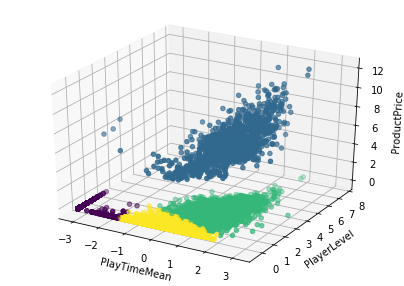

In [31]:
plt.figure('Iris dataset', figsize=(7,5))
ax = plt.axes(projection = '3d')
ax.scatter(X_train_scale[:,0],X_train_scale[:,1],X_train_scale[:,2],c=list(r['predict']))
ax.set_xlabel('PlayTimeMean')
ax.set_ylabel('PlayerLevel')
ax.set_zlabel('ProductPrice')
;

- 그룹 0 (보라색) 은 플레이타임, 레벨, 과금 모두 낮은 편을 보이고 있다. 이들은 게임에 크게 흥미를 가지지 않은 것으로 보인다.
- 총 57173명 중 3736명 (6.5%)

- 그룹 1 (파란색) 은 평균플레이 타임도 평균이상인 편이고, 레벨도 어느정도 육성했지만, 과금에는 크게 흥미를 보이지 않는 것으로 보인다. 하지만, 플레이타임이나 레벨로 보아 새로운 컨텐츠나 흥미로운 요소를 통해 플레이시간을 더 늘릴 수 있다면 진성유저로 성장할 수 있는 가능성이 매우 높은 그룹이다.
- 총 57173명 중 8704명 (15.2%)

- 그룹 2 (초록색) 은 플레이타임, 레벨, 과금 모두 높다. 이들을 진성유저라고 할 수 있으며, 계속해서 게임을 할 수 있게끔 지원해야 한다.
- 총 57173명 중 1193명 (2.1%)

- 그룹 3 (노란색) 은 평균 게임시간 자체는 낮지 않지만, 레벨이 낮고, 과금 또한 얼마 하지 않은 라이트 유저일 것이다. 이들에게 게임의 재미를 알려줄 수 있게끔 아이템이나 지원한다거나 새로운 컨텐츠를 제공해야 한다.
- 총 57173명 중 43540명 (76.2%)

# 선택 과제 2 유저 이탈 감지

## 타겟변수 만들기

### 유저 이탈의 기준
- 3개월 이상 장기 미접속자로 규정
- 최종데이터인 2020-01-13 기준 3개월 이상 미접속자
- 단 19,20년에 한해서는 19년까지의 데이터만 있으므로 6개월 이상 장기 미접속자 (취소)

- 처음에는 6개월 기준으로 하려고 했으나, 6개월 기준시 약 5만개 데이터 중 장기 미접속자가 80여명 밖에 되지 않음. 따라서 이를 좀 더 유연하게 하고자 3개월 기준으로 함.


In [32]:
action.sort_values(by=['logdate'],axis=0).tail(1) #최종 데이터 2020-01-13

,UID,logdate,PlayTime,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,TotalEquipments,...,Tier6Equip,Tier7Equip,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,isClanMember,PlayerLevel
66474,28330865,2020-01-13,79,0,0,0,27089,0,27089,0,...,0,0,0,0,0,0,0,0,Y,38


In [33]:
data=action.sort_values(by=['UID','logdate'],axis=0)
data.reset_index(inplace=True)
data['이탈유저']=''
del data['index']

In [34]:
for i in range(len(data)-1):
    if data['UID'][i]==data['UID'][i+1]:
        if (datetime.strptime(data['logdate'][i+1], '%Y-%m-%d').date()-datetime.strptime(data['logdate'][i], '%Y-%m-%d').date()).days>90:
            data['이탈유저'][i]=1
            
# for i in range(len(data)-1):
#     if data['logdate'][i][0:4] in ['2019','2020']:
#         if data['UID'][i]==data['UID'][i+1]:
#             if (datetime.strptime(data['logdate'][i+1], '%Y-%m-%d').date()-datetime.strptime(data['logdate'][i], '%Y-%m-%d').date()).days>91:
#                 data['이탈유저'][i]=1        
                
for i in range(len(data)-1):
    if data['UID'][i+1] != data['UID'][i]:
        if (datetime.strptime('2020-01-13', '%Y-%m-%d').date()-datetime.strptime(data['logdate'][i], '%Y-%m-%d').date()).days>90:
            data['이탈유저'][i]=1
            
for i in range(len(data)):
    if data['이탈유저'][i]=='':
        data['이탈유저'][i]=0

In [35]:
data['이탈유저'] = pd.to_numeric(data['이탈유저'])

In [37]:
print('이탈유저는 총 ', len(data[data['이탈유저']>0]),'명')

이탈유저는 총  6515 명


## feature engineering

In [38]:
data[data['이탈유저']==0].groupby('UID').mean().describe()

,PlayTime,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,TotalEquipments,Tier1Equip,Tier2Equip,...,Tier6Equip,Tier7Equip,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,PlayerLevel,이탈유저
count,51863.000000,5.186300e+04,51863.000000,51863.000000,5.186300e+04,5.186300e+04,5.186300e+04,51863.000000,51863.000000,51863.000000,...,51863.000000,51863.000000,51863.000000,51863.000000,51863.000000,51863.000000,51863.000000,51863.000000,51863.000000,51863.0
mean,1466.398368,1.609396e+03,918.356454,573.912527,5.664453e+04,7.062916e+04,6.760871e+04,0.765318,0.640897,0.077321,...,0.001135,0.000238,0.000049,0.000036,0.000125,0.815516,0.089325,1.588629,6.389123,0.0
std,3034.402212,7.832200e+03,3797.636106,3468.995380,2.284540e+05,7.406202e+05,7.231939e+05,0.799480,0.708075,0.288491,...,0.018059,0.007319,0.002347,0.003931,0.022998,0.931340,0.369222,4.383200,10.305438,0.0
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
25%,231.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,568.000000,7.500000e+01,0.000000,0.000000,3.013800e+04,2.203000e+03,2.065000e+03,0.857143,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0
75%,1527.275641,1.272000e+03,980.000000,13.291667,3.585792e+04,1.280175e+04,8.296500e+03,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,7.000000,0.0
max,232211.250000,1.023122e+06,448608.347826,441933.478261,2.383054e+07,1.202336e+08,1.183393e+08,7.000000,4.000000,4.000000,...,2.514632,1.248234,0.292929,0.813075,5.085802,19.720000,19.560000,137.000000,90.798774,0.0


In [39]:
data[data['이탈유저']==1].groupby('UID').mean().describe()

,PlayTime,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,TotalEquipments,Tier1Equip,Tier2Equip,...,Tier6Equip,Tier7Equip,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,PlayerLevel,이탈유저
count,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6.510000e+03,6.510000e+03,6510.000000,6510.000000,6510.000000,...,6510.000000,6510.0,6510.0,6510.0,6510.0,6510.000000,6510.000000,6510.000000,6510.000000,6510.0
mean,1040.344624,709.320609,390.968049,187.951715,26090.695161,1.303804e+04,1.310213e+04,0.611188,0.548233,0.047696,...,0.000461,0.0,0.0,0.0,0.0,0.622094,0.032719,0.845827,3.675576,1.0
std,7224.062370,1480.632735,1166.434812,1056.217470,40149.347723,7.549125e+04,9.794156e+04,0.853109,0.754752,0.275892,...,0.037182,0.0,0.0,0.0,0.0,0.912014,0.268724,3.542354,6.295958,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,1.0
25%,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,1.0
50%,376.000000,0.000000,0.000000,0.000000,30000.000000,6.470000e+02,2.800000e+02,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,1.0
75%,893.750000,1125.000000,125.000000,0.000000,34912.000000,6.832000e+03,2.116000e+03,1.000000,1.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,4.000000,1.0
max,371622.000000,37077.000000,26030.000000,23727.000000,988399.000000,2.493835e+06,4.743273e+06,6.000000,4.000000,4.000000,...,3.000000,0.0,0.0,0.0,0.0,9.000000,6.000000,52.000000,82.000000,1.0


- 이탈유저와 일반유저의 구별은 눈으로 봤을 때 뚜렷하게 두드러지는 특징은 잘 보이지 않는다. 변수와의 조화를 통해 그 차이를 알아봐야 한다.

### 총 플레이 일수, 접속주기 변수 생성

In [40]:
data['totalplaydate']=''
data['meanplaydate']=''

In [41]:
temp=[]
for i in range(len(data)-1):
    if data['UID'][i]==data['UID'][i+1]:
        
        temp.append(datetime.strptime(data['logdate'][i], '%Y-%m-%d'))
        data['totalplaydate'][i]=(max(temp)-min(temp)).days+1
    if data['UID'][i]!=data['UID'][i+1]:
        if len(temp)==0:
            data['totalplaydate'][i]=1
        else:
            data['totalplaydate'][i]=(max(temp)-min(temp)).days+1
        temp=[]

In [42]:
var=data.groupby('UID').max()

In [43]:
var['totalplaydate'] = pd.to_numeric(var['totalplaydate'])

In [44]:
tempdf=pd.merge(var['totalplaydate'],data.groupby('UID').count()['logdate'],on='UID')
tempdf['accessperiod']=''
tempdf.reset_index(inplace=True)
tempdf['totalplaydate'][57172]=1 #위 식에서 range를 n-1로 잡았기 때문에 마지막 값은 수동입력

In [45]:
for i in range(len(tempdf)):
    tempdf['accessperiod'][i]=tempdf['logdate'][i]/tempdf['totalplaydate'][i]

In [46]:
del tempdf['logdate']

In [47]:
tempdf.head(5)

,UID,totalplaydate,accessperiod
0,1072937,1.0,1
1,1072938,1.0,1
2,1073002,1.0,1
3,1073004,4.0,1.5
4,1073096,1.0,2


### 접속주기당 플레이 타임

In [48]:
temp2=action.groupby('UID').sum()
temp2.reset_index(inplace=True)

In [49]:
tempdf=pd.merge(tempdf,temp2,on='UID')

In [50]:
tempdf['playtimeperaccesstime']=''
for i in range(len(tempdf)):
    tempdf['playtimeperaccesstime'][i]=tempdf['PlayTime'][i]/tempdf['accessperiod'][i]
#tempdf['playtimeperaccesstime']=tempdf.apply(lambda x: tempdf['PlayTime'] / tempdf['accessperiod'],axis=1) #메모리 오류

In [51]:
tempdf.head(5)

,UID,totalplaydate,accessperiod,PlayTime,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,...,Tier6Equip,Tier7Equip,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,PlayerLevel,playtimeperaccesstime
0,1072937,1.0,1,304,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,304
1,1072938,1.0,1,320,0,0,0,29390,1170,1470,...,0,0,0,0,0,1,0,0,1,320
2,1073002,1.0,1,0,0,0,0,30460,1510,1111,...,0,0,0,0,0,1,0,0,4,0
3,1073004,4.0,1.5,13866,5642,14525,12851,406931,512539,429352,...,0,0,0,0,0,9,6,52,116,9244
4,1073096,1.0,2,306,0,0,0,29700,1480,1470,...,0,0,0,0,0,1,0,0,2,153


### 다이아몬드, 코인
가장 많이 고민한 변수인데, 처음엔 접속주기당 다이아몬드, 코인의 보유-사용 갯수를 사용하려고 했으나, 과금이라는 특성상 갑자기 다이아몬드와 코인이 들어올 수도 있고, 휴면유저 등 다양한 변수를 고려해야 한다. 또한, 접속주기라는 변수를 너무 많이 사용하면 모형 과적합 될 수 있다.
따라서 어떤 변수로 나눠주는 것이 아닌, 총합을 사용하되, 필요시 로그변환 등 적절한 조치를 취해준다.

### 장비 티어
장비의 티어는 좋은 변수가 될 수 있다. 티어가 낮은 장비를 사용하는 것은 저레벨 유저일수 있고, 높은 장비를 사용하는 것은 고레벨 장비일 수 도 있다. 이것 또한 절댓값을 변수로 사용한다.
단 장비 Total값은 삭제한다.

### 최대레벨
처음엔, 기간당 레벨을 얼마나 올렸는지에 대해 변수로 사용하고자 했으나, 게임을 오래 할수록 대부분의 게임이 레벨업 하기 어려워지는 점을 고려해서 최대레벨 변수를 사용한다.

In [52]:
LevelMax=pd.DataFrame(LevelMax) #과제1의 변수 사용
LevelMax.columns=['LevelMax']

In [53]:
tempdf=pd.merge(tempdf,LevelMax, on='UID') 

In [54]:
tempdf.head(5)

,UID,totalplaydate,accessperiod,PlayTime,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,...,Tier7Equip,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,PlayerLevel,playtimeperaccesstime,LevelMax
0,1072937,1.0,1,304,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,304,1
1,1072938,1.0,1,320,0,0,0,29390,1170,1470,...,0,0,0,0,1,0,0,1,320,1
2,1073002,1.0,1,0,0,0,0,30460,1510,1111,...,0,0,0,0,1,0,0,4,0,4
3,1073004,4.0,1.5,13866,5642,14525,12851,406931,512539,429352,...,0,0,0,0,9,6,52,116,9244,23
4,1073096,1.0,2,306,0,0,0,29700,1480,1470,...,0,0,0,0,1,0,0,2,153,1


### 클랜 소속 유무

In [55]:
clan=action
clan['isclanmember']=''
for i in range(len(clan)):
    if clan['isClanMember'][i]=='N':
        clan['isclanmember'][i]=0
    else:
        clan['isclanmember'][i]=1

In [56]:
clan['isclanmember'] = pd.to_numeric(clan['isclanmember'])

In [57]:
clan2=clan.groupby('UID').min()['isclanmember']

In [58]:
clan2=pd.DataFrame(clan2)
clan2.reset_index(inplace=True)

In [59]:
tempdf=pd.merge(tempdf,clan2,on='UID')

In [60]:
tempdf.head(5)

,UID,totalplaydate,accessperiod,PlayTime,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,...,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,PlayerLevel,playtimeperaccesstime,LevelMax,isclanmember
0,1072937,1.0,1,304,0,0,0,0,0,0,...,0,0,0,0,0,0,1,304,1,0
1,1072938,1.0,1,320,0,0,0,29390,1170,1470,...,0,0,0,1,0,0,1,320,1,0
2,1073002,1.0,1,0,0,0,0,30460,1510,1111,...,0,0,0,1,0,0,4,0,4,0
3,1073004,4.0,1.5,13866,5642,14525,12851,406931,512539,429352,...,0,0,0,9,6,52,116,9244,23,0
4,1073096,1.0,2,306,0,0,0,29700,1480,1470,...,0,0,0,1,0,0,2,153,1,0


## 모형적합

### 변수 정리

#### X_Dataset

In [61]:
tempdf

,UID,totalplaydate,accessperiod,PlayTime,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,...,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,PlayerLevel,playtimeperaccesstime,LevelMax,isclanmember
0,1072937,1.0,1,304,0,0,0,0,0,0,...,0,0,0,0,0,0,1,304,1,0
1,1072938,1.0,1,320,0,0,0,29390,1170,1470,...,0,0,0,1,0,0,1,320,1,0
2,1073002,1.0,1,0,0,0,0,30460,1510,1111,...,0,0,0,1,0,0,4,0,4,0
3,1073004,4.0,1.5,13866,5642,14525,12851,406931,512539,429352,...,0,0,0,9,6,52,116,9244,23,0
4,1073096,1.0,2,306,0,0,0,29700,1480,1470,...,0,0,0,1,0,0,2,153,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57168,29607412,1.0,1,1484,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1484,1,0
57169,29607528,1.0,1,525,0,0,0,29720,1200,280,...,0,0,0,1,0,0,1,525,1,0
57170,29607552,1.0,1,145,0,0,0,0,0,0,...,0,0,0,0,0,0,1,145,1,0
57171,29607577,1.0,1,1123,0,0,0,31677,2203,280,...,0,0,0,1,0,0,1,1123,1,0


In [62]:
tempdf=tempdf.drop(['PlayTime','PlayerLevel','TotalEquipments','PlayerLevel'], axis=1)

In [63]:
tempdf

,UID,totalplaydate,accessperiod,haveDiamonds,getDiamonds,useDiamonds,haveCoin,getCoin,useCoin,Tier1Equip,...,Tier7Equip,Tier8Equip,Tier9Equip,Tier10Equip,makeEquip,sellEquip,UpgradeEquip,playtimeperaccesstime,LevelMax,isclanmember
0,1072937,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,304,1,0
1,1072938,1.0,1,0,0,0,29390,1170,1470,1,...,0,0,0,0,1,0,0,320,1,0
2,1073002,1.0,1,0,0,0,30460,1510,1111,1,...,0,0,0,0,1,0,0,0,4,0
3,1073004,4.0,1.5,5642,14525,12851,406931,512539,429352,4,...,0,0,0,0,9,6,52,9244,23,0
4,1073096,1.0,2,0,0,0,29700,1480,1470,1,...,0,0,0,0,1,0,0,153,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57168,29607412,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1484,1,0
57169,29607528,1.0,1,0,0,0,29720,1200,280,1,...,0,0,0,0,1,0,0,525,1,0
57170,29607552,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,145,1,0
57171,29607577,1.0,1,0,0,0,31677,2203,280,1,...,0,0,0,0,1,0,0,1123,1,0


In [64]:
tempdf=tempdf[['totalplaydate','accessperiod','playtimeperaccesstime','LevelMax','isclanmember',
               'haveDiamonds', 'getDiamonds', 'useDiamonds',
               'haveCoin', 'getCoin', 'useCoin',
               'Tier1Equip', 'Tier2Equip', 'Tier3Equip', 'Tier4Equip', 'Tier5Equip',
               'Tier6Equip', 'Tier7Equip', 'Tier8Equip', 'Tier9Equip', 'Tier10Equip',
               'makeEquip', 'sellEquip', 'UpgradeEquip']]
backup=tempdf

In [65]:
min_max=MinMaxScaler()

In [66]:
tempdf
tempdf=min_max.fit_transform(tempdf) #변수 정규화

In [67]:
tempdf=pd.DataFrame(tempdf,columns=backup.columns)

In [68]:
X=tempdf

#### Y_Dataset

In [69]:
Y=data.groupby('UID').min()['이탈유저']

In [70]:
Y=pd.DataFrame(Y)

In [71]:
Y.reset_index(inplace=True)

In [72]:
Y=Y['이탈유저']

In [73]:
Y

0        1
1        1
2        1
3        0
4        0
        ..
57168    0
57169    0
57170    0
57171    0
57172    0
Name: 이탈유저, Length: 57173, dtype: int64

### 신경망 모형 Fitting

In [74]:
print("Total Dataset Shape")
print(X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
X_train = np.nan_to_num(X_train)
print("Train / Test Set Size")
print(len(X_train), len(Y_train), len(X_test), len(Y_test))

Total Dataset Shape
(57173, 24)
Train / Test Set Size
40021 40021 17152 17152


In [75]:
np.random.seed(5)

In [76]:
LEARNING_RATE = 0.03
DROPOUT_RATIO = 0.3
BATCH_SIZE = 100
EPSILON = 0.01 

def delay_model(x_size, y_size):
    model = Sequential()
    model.add(Dense(30, activation='relu', input_shape=(x_size, )))
    Dropout(DROPOUT_RATIO)
    model.add(Dense(15, activation='relu'))
    Dropout(DROPOUT_RATIO)
    model.add(Dense(y_size, activation='sigmoid'))
    print(model.summary())
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=LEARNING_RATE, epsilon=EPSILON),
                  metrics=['accuracy'])
    return model

In [77]:
model1 = delay_model(x_size=X_train.shape[1], y_size=1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                750       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
history = model1.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=5, verbose=1, validation_data=(X_test, Y_test), shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 40021 samples, validate on 17152 samples
Epoch 1/5
40021/40021 [==============================] - 2s 52us/step - loss: 0.3085 - acc: 0.9056 - val_loss: 0.2924 - val_acc: 0.9070
Epoch 2/5
40021/40021 [==============================] - 1s 23us/step - loss: 0.2877 - acc: 0.9072 - val_loss: 0.2872 - val_acc: 0.9070
Epoch 3/5
40021/40021 [==============================] - 1s 23us/step - loss: 0.2845 - acc: 0.9072 - val_loss: 0.2870 - val_acc: 0.9070
Epoch 4/5
40021/40021 [==============================] - 1s 23us/step - loss: 0.2832 - acc: 0.9072 - val_loss: 0.2846 - val_acc: 0.9070
Epoch 5/5
40021/40021 [==============================] - 1s 23us/step - loss: 0.2828 - acc: 0.9072 - val_loss: 0.2864 - val_acc: 0.9070


### 모델 성능 평가

모델의 성능은 전체 데이터 중 얼마나 정확하게 맞췄는지에 대한 'Accuracy'를 기준으로 한다.

In [79]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['acc'])
    plt.plot(h['val_acc'])
    plt.title('Training vs Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

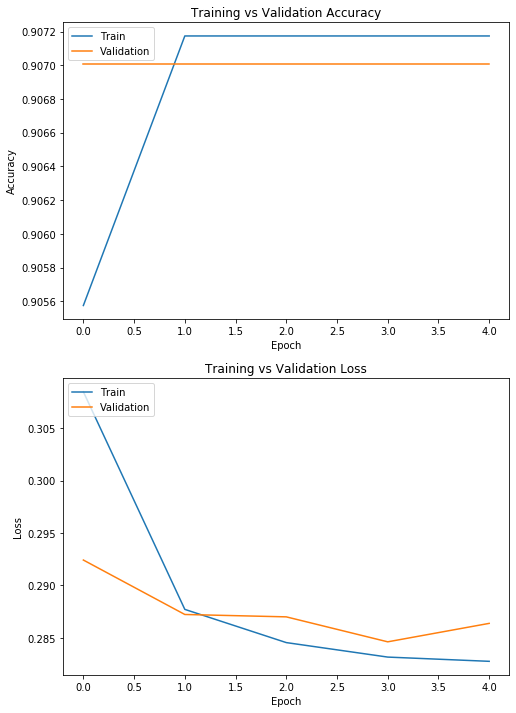

In [80]:
plot_hist(history.history, xsize=8, ysize=12)

In [81]:
results = model1.evaluate(X_test, Y_test)

17152/17152 [==============================] - 0s 21us/step


In [82]:
print('손실률 : ', format(results[0],'.2f'), '정확도 : ', format(results[1],'.2f'))

손실률 :  0.29 정확도 :  0.91


## 한계점
- 다이아몬드, 코인에 대해 충분히 고려하지 않았다. 특히, 보유, 소모에 대한 인사이트가 존재할 것 같은데 이를 무시하고 총량에 대해서만 변수로 사용했다.
- 장비에 대해서 충분히 고려하지 않았다. 장비를 티어제로 나눠놓은 이유가 분명 있을텐데 이에 대해 크게 신경쓰지 못했다.
- 일자별 유저데이터를 기준으로 머신러닝을 했다면 이탈에 대해서 좀 더 정확하게 분석하고, 이탈시점 또한 예측할 수 있을거 같은데 사람한명에 대해 한 데이터(총합 or 평균)만 사용했기 때문에 다소 부정확하다.
- 약 5만개의 데이터의 데이터를 사용했기 때문에 과적합 문제가 분명히 있다.

## 이탈률을 낮추기 위해
- 서브이벤트나 복귀유저를 위한 컨텐츠, 아이템을 통해 이탈을 방지한다.
- 계속해서 새로운 컨텐츠를 만들고, 더 많은 유저를 품을 수 있도록 한다.